In [37]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support, classification_report,confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import utils  
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, ParameterGrid
import math
import torch
from scipy.io import arff
from sklearn.datasets import make_classification
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from tqdm import tqdm
from utils import set_seed, split_data, split_vector, create_Y, local_seed, ExplorationParams, Data
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from training import NonStrategicTrainer, StrategicTrainer, IterativeCausalStrategicTrainer, IterativeNonStrategicTrainer, IterativeStrategicTrainer, CausalStrategicTrainerWithU
from testing import test_strategic, test, test_strategic_only_X2_model
from model import cross_entropy_loss_for_h, hinge_loss, MLP, HelperModel
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from distribution import RealPositiveAndGenerativeNegetiveDistribution, SequentialDistribution
from delta import QuadraticCostDelta, create_cost_functions
from plot_data import plot_coefs
from records import ExpResults

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def load_card_fraud_data(seed, features_order=None):
    set_seed(0)
    df = pd.read_csv('./datasets/creditcard.csv')

    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df.drop(['Time', 'Amount'], axis=1, inplace=True)
    scaled_amount = df['scaled_amount']
    df.drop(['scaled_amount'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)

    df["Class"].replace({1: -1, 0: 1}, inplace=True)

    # Shuffle dataframe rows
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    Y = df['Class'].values
    X = df.drop('Class', axis=1).values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    # change column order
    if features_order:
        X = X[:, features_order]
    return torch.from_numpy(X).float(), torch.from_numpy(Y).float()

### linear model on the original data

In [5]:
set_seed(0)
X, Y = load_card_fraud_data(0)
X_pos, Y_pos = X[Y == 1], Y[Y == 1]
X_neg, Y_neg = X[Y == -1], Y[Y == -1]
X_pos.shape, Y_pos.shape

(torch.Size([284315, 29]), torch.Size([284315]))

In [6]:
# sub-sample positives
n_pos_samples = 500
X_pos, Y_pos = X_pos[:n_pos_samples], Y_pos[:n_pos_samples]
X_neg_train, Y_neg_train, X_neg_test, Y_neg_test = split_data(X_neg, Y_neg, 0.2)

In [7]:
# create balance test
pos_test_ratio = Y_neg_test.shape[0] / Y_pos.shape[0]
# split positive samples to train and test
X_pos_train, Y_pos_train, X_pos_test, Y_pos_test = split_data(X_pos, Y_pos, pos_test_ratio)
# create test
X_test, Y_test = torch.concat([X_pos_test, X_neg_test], 0), torch.concat([Y_pos_test, Y_neg_test], 0)
# create train
X_train, Y_train = torch.concat([X_pos_train, X_neg_train], 0), torch.concat([Y_pos_train, Y_neg_train], 0)

In [8]:
# train linear model
lr = LogisticRegression(random_state=0).fit(X_train, Y_train)
preds = lr.predict(X_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.9540816326530612


In [9]:
# train linear model with lasso
lr_lasso = LogisticRegression(random_state=0, penalty='l1', C=1, solver='liblinear').fit(X_train, Y_train)
preds = lr_lasso.predict(X_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.9540816326530612


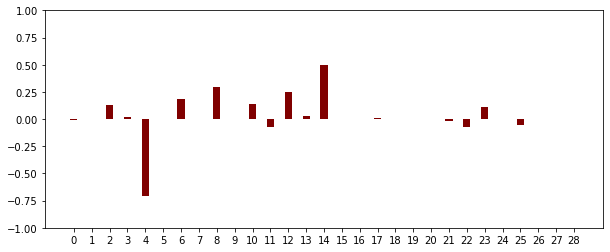

In [10]:
plot_coefs(torch.Tensor(lr_lasso.coef_[0]))

In [11]:
# correlation matrix
df = pd.DataFrame(data = torch.concat([Y_train.view(-1, 1), X_train], 1).numpy(), columns = ['y'] + [f"x{i}" for i in range(29)])
corr_matrix = df.corr()#.abs()
corr_matrix.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '10px'})

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28
y,1.000000,-0.055724,0.437112,-0.487926,0.561035,-0.719912,0.371335,0.411083,0.469921,-0.055032,0.548522,0.620483,-0.693699,0.684674,0.006661,0.749308,0.102521,0.588065,0.559503,0.475834,-0.272177,-0.176809,-0.125211,0.007080,0.023604,0.140650,-0.065332,-0.064875,-0.027523,-0.124758
x0,-0.055724,1.000000,-0.032156,-0.200439,-0.031941,0.007335,-0.157263,0.190286,0.147090,0.029051,0.019547,-0.029937,-0.010536,0.009937,0.011026,0.021656,0.009596,-0.018516,-0.037734,-0.024759,0.070656,0.092463,0.008163,0.000748,-0.132216,-0.042001,-0.103007,-0.012258,0.136182,-0.184017
x1,0.437112,-0.032156,1.000000,-0.837264,0.891721,-0.610452,0.869266,0.309907,0.884985,-0.071023,0.671824,0.750591,-0.516331,0.584369,-0.052009,0.421750,0.158895,0.632542,0.677605,0.679221,-0.302903,-0.326613,-0.002121,-0.007099,-0.031924,-0.086160,-0.111838,0.089466,0.250725,0.146544
x2,-0.487926,-0.200439,-0.837264,1.000000,-0.871513,0.685450,-0.800700,-0.266377,-0.858201,-0.042529,-0.700017,-0.774740,0.614829,-0.659561,0.048710,-0.541433,-0.189963,-0.633370,-0.646684,-0.636945,0.227028,0.307244,0.051830,-0.023160,0.137405,0.023251,0.153303,-0.044356,-0.222117,0.055082
x3,0.561035,-0.031941,0.891721,-0.871513,1.000000,-0.757874,0.862827,0.431908,0.878121,-0.166512,0.759563,0.855190,-0.687938,0.742915,-0.086252,0.623045,0.191568,0.720582,0.740388,0.711815,-0.316845,-0.360244,0.018546,-0.044725,-0.012403,-0.011017,-0.138320,0.015794,0.178297,0.088645
x4,-0.719912,0.007335,-0.610452,0.685450,-0.757874,1.000000,-0.578075,-0.442822,-0.694333,0.097997,-0.779043,-0.796655,0.784779,-0.834810,0.056502,-0.776799,-0.184340,-0.722982,-0.717592,-0.655328,0.307032,0.303976,-0.021155,0.108743,-0.005425,-0.105616,-0.001798,0.101245,-0.110241,-0.018412
x5,0.371335,-0.157263,0.869266,-0.800700,0.862827,-0.578075,1.000000,0.287552,0.816837,-0.199921,0.661204,0.760605,-0.508118,0.606121,-0.129466,0.409875,0.127425,0.684303,0.743010,0.745318,-0.396153,-0.307233,0.042511,-0.083123,-0.064509,-0.137965,-0.119117,0.099359,0.222208,0.175324
x6,0.411083,0.190286,0.309907,-0.266377,0.431908,-0.442822,0.287552,1.000000,0.259142,-0.582988,0.338533,0.384910,-0.494001,0.487388,-0.142213,0.516806,-0.030226,0.425026,0.413728,0.350521,-0.223838,-0.121816,0.043725,0.004274,0.346626,-0.003491,-0.163037,-0.052147,-0.104061,-0.064736
x7,0.469921,0.147090,0.884985,-0.858201,0.878121,-0.694333,0.816837,0.259142,1.000000,0.116046,0.760733,0.856201,-0.603637,0.692513,-0.019374,0.499629,0.215744,0.729877,0.753432,0.755573,-0.333386,-0.393753,0.031103,-0.095074,-0.074680,-0.061447,0.017882,0.059638,0.325261,0.095910
x8,-0.055032,0.029051,-0.071023,-0.042529,-0.166512,0.097997,-0.199921,-0.582988,0.116046,1.000000,-0.056641,-0.028264,0.164415,-0.157492,0.290343,-0.182685,0.151388,-0.162117,-0.214080,-0.172741,0.215755,-0.038895,-0.131541,0.045946,-0.453743,0.091130,0.250030,0.030936,0.280964,-0.014135


### split features

In [19]:
total_dim = 29
x1_features = [1, 6, 17, 0, 13, 15]
x2_features = [5, 7, 9, 10, 11, 14] 
u_features = x2_features + list(set([i for i in range(total_dim)]) - set(x1_features) - set(x2_features))
features_order = x1_features + u_features
x1_dim = len(x1_features)
x2_dim = len(x2_features)
# u_dim = len(u_features)
u_dim = 16 # 16 # 25


def load_data(seed):
    X, Y = load_card_fraud_data(seed, features_order)
    X = X[:, :x1_dim + u_dim]
    return X, Y

In [162]:
x1_dim, u_dim

(6, 16)

In [163]:
set_seed(0)
A = torch.rand(x2_dim, x2_dim)

def u_to_x2(U):
    # keep only x2 features
    X2 = U[:, :x2_dim]
    # linear transform
    batch_matrix = A.expand(X2.shape[0], X2.shape[1], X2.shape[1])
    batch_vectors = torch.unsqueeze((X2), 2)
    X2 = torch.bmm(batch_matrix, batch_vectors)
    X2 = torch.squeeze(X2, 2)
    return X2

### test linear model on original data, splited

In [164]:
# load data
set_seed(0)
X, Y = load_data(0)
X_pos, Y_pos = X[Y == 1], Y[Y == 1]
X_neg, Y_neg = X[Y == -1], Y[Y == -1]

In [165]:
# sub-sample positives
n_pos_samples = 500
X_pos, Y_pos = X_pos[:n_pos_samples], Y_pos[:n_pos_samples]
X_neg_train, Y_neg_train, X_neg_test, Y_neg_test = split_data(X_neg, Y_neg, 0.2)
# create balance test
pos_test_ratio = Y_neg_test.shape[0] / Y_pos.shape[0]
# split positive samples to train and test
X_pos_train, Y_pos_train, X_pos_test, Y_pos_test = split_data(X_pos, Y_pos, pos_test_ratio)
# create test
X_test, Y_test = torch.concat([X_pos_test, X_neg_test], 0), torch.concat([Y_pos_test, Y_neg_test], 0)
# create train
X_train, Y_train = torch.concat([X_pos_train, X_neg_train], 0), torch.concat([Y_pos_train, Y_neg_train], 0)

In [166]:
X1_train, U_train = split_vector(X_train, x1_dim)
X1_test, U_test = split_vector(X_test, x1_dim)
X2_train, X2_test = u_to_x2(U_train), u_to_x2(U_test)
X1X2_train, X1X2_test = torch.concat([X1_train, X2_train], 1), torch.concat([X1_test, X2_test], 1) 

In [167]:
# train linear model only x1
lr = LogisticRegression(random_state=0).fit(X1_train, Y_train)
preds = lr.predict(X1_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.8316326530612245


In [168]:
# train linear model only x2
lr = LogisticRegression(random_state=0).fit(X2_train, Y_train)
preds = lr.predict(X2_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.9285714285714286


In [169]:
# train linear model on x1,x2
lr = LogisticRegression(random_state=0).fit(X1X2_train, Y_train)
preds = lr.predict(X1X2_test)
acc = accuracy_score(Y_test, preds)
print(f"linear model acc: {acc}")

linear model acc: 0.9336734693877551


### create h*

In [170]:
# load data
set_seed(0)
X, Y = load_data(0)
X_pos, Y_pos = X[Y == 1], Y[Y == 1]
X_neg, Y_neg = X[Y == -1], Y[Y == -1]
# sub-sample positives
n_pos_samples = 500
X_pos, Y_pos = X_pos[:n_pos_samples], Y_pos[:n_pos_samples]
X_neg_train, Y_neg_train, X_neg_test, Y_neg_test = split_data(X_neg, Y_neg, 0.2)
# create balance test
pos_test_ratio = Y_neg_test.shape[0] / Y_pos.shape[0]
# split positive samples to train and test
X_pos_train, Y_pos_train, X_pos_test, Y_pos_test = split_data(X_pos, Y_pos, pos_test_ratio)
# create test
X_test, Y_test = torch.concat([X_pos_test, X_neg_test], 0), torch.concat([Y_pos_test, Y_neg_test], 0)
# create train
X_train, Y_train = torch.concat([X_pos_train, X_neg_train], 0), torch.concat([Y_pos_train, Y_neg_train], 0)
# shuffle train
perm = torch.randperm(X_train.size()[0]) 
X_train, Y_train = X_train[perm], Y_train[perm]

In [171]:
# learning params
batch_size = 64
lr = 0.01
epochs = 100
tau = 4

In [172]:
X_train, Y_train, X_val, Y_val = split_data(X_train, Y_train, 0.4)
h_star_train_ds = TensorDataset(X_train, Y_train)
h_star_train_dl = DataLoader(h_star_train_ds, batch_size=batch_size, shuffle=True)

In [173]:
h_star = MLP(in_dim=x1_dim + u_dim, out_dim=1, hidden_dim=10, hidden_layers=3)
opt = Adam(h_star.parameters(), lr=lr)
trainer = NonStrategicTrainer(h_star, h_star_train_dl, X_val, Y_val, X_test, Y_test, opt, cross_entropy_loss_for_h)
trainer.train(100)
print("\nh_star creation:")
trainer.test()

trained 16 epochs. val acc: 0.9308176100628931

h_star creation:
	Accuracy: 0.9642857142857143


0.9642857142857143

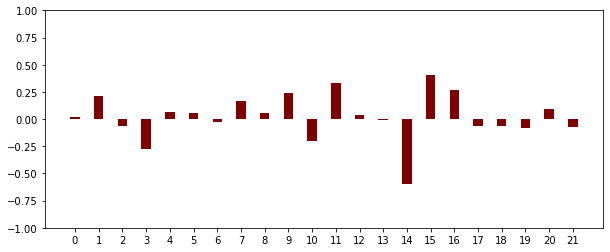

In [174]:
# calculate gradient with respect to input
grads_list = []
for i in range(len(X_train)):
    x = X_train[i]
    x.requires_grad = True
    out = h_star(x)
    grads_list.append(torch.autograd.grad(out, x, retain_graph=True)[0].data.view(1, -1))
    
grads = torch.concat(grads_list, 0)
grads_mean = grads.mean(0)
plot_coefs(grads_mean)

### modify h*

In [175]:
class StochasticModel:
    def __init__(self, h_star, max_flip_prob, slope):
        if not 0 <= max_flip_prob <= 0.5:
            raise ValueError(f"max_flip_prob = {max_flip_prob}. it should be 0 <= max_flip_prob <= 0.5")
        if slope <= 0:
            raise ValueError(f"slope = {slope}. it should be 0 < slop")
        self.h_star = h_star
        self.max_flip_prob = max_flip_prob
        self.slope = slope
    
    def flip_scores(self, scores):
        new_scores = scores.detach().clone()
        with local_seed(0):
            probs_for_flip = torch.relu(self.max_flip_prob - self.slope * new_scores.abs())
            flip_mask = torch.bernoulli(probs_for_flip).bool()
            # flip scores
            new_scores[flip_mask] *= -1
        return new_scores
    
    def __call__(self, X):
        scores = self.h_star(X)
        new_scores = self.flip_scores(scores)
        # print stats
        flip_rate = (scores != new_scores).float().mean().item()
        print(f"StochasticModel: {round(flip_rate * 100, 2)}% flips")
        return new_scores

In [176]:
s_h_star = StochasticModel(h_star, 0.5, 0.04) #0.04

In [177]:
a = s_h_star(X_train)

StochasticModel: 24.9% flips


### create simulative data

In [178]:
# samples params
time_steps = 10
n_clean_train_samples = 1000
n_samples_per_round = 200
n_val_samples = 500
n_test_samples = 2000

In [179]:
n_features = x1_dim + x2_dim
total_n_train_samples = n_clean_train_samples + time_steps * n_samples_per_round
total_n_val_test_samples = n_val_samples + n_test_samples
total_n_samples = total_n_train_samples + total_n_val_test_samples
val_test_frac = total_n_val_test_samples / total_n_samples
test_frac = n_test_samples / total_n_val_test_samples

In [180]:
# create distribution
dist = RealPositiveAndGenerativeNegetiveDistribution(x1_dim, u_to_x2, load_data, seed=0, h_star=s_h_star)
# create data
X_U = dist.sample(total_n_samples)
X, U = split_vector(X_U, n_features)
Y = create_Y(X, U, s_h_star, x1_dim)
# split data to train, val, test
X_U_train, Y_train, X_U_val, Y_val = split_data(X_U, Y, val_test_frac)
X_U_val, Y_val, X_U_test, Y_test = split_data(X_U_val, Y_val, test_frac)
X_train, U_train = split_vector(X_U_train, n_features)
X_val, U_val = split_vector(X_U_val, n_features)
X_test, U_test = split_vector(X_U_test, n_features)
# split x1, x2
X1_train, X2_train = split_vector(X_train, x1_dim)
X1_val, X2_val = split_vector(X_val, x1_dim)
X1_test, X2_test = split_vector(X_test, x1_dim)

StochasticModel: 27.67% flips
StochasticModel: 20.11% flips
StochasticModel: 27.24% flips
StochasticModel: 19.35% flips
StochasticModel: 20.8% flips


In [181]:
# create datasets objects
full_data = Data(X_train, Y_train, U_train, X_val, Y_val, U_val, X_test, Y_test, U_test)
clean_data = Data(X_train[:n_clean_train_samples], Y_train[:n_clean_train_samples], U_train[:n_clean_train_samples], X_val, Y_val, U_val, X_test, Y_test, U_test)
X1_clean_data = Data(X1_train[:n_clean_train_samples], Y_train[:n_clean_train_samples], U_train[:n_clean_train_samples], X1_val, Y_val, U_val, X1_test, Y_test, U_test)
X2_full_data = Data(X2_train, Y_train, U_train, X2_val, Y_val, U_val, X2_test, Y_test, U_test)

full_train_dl = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
X_U_train_dl = DataLoader(TensorDataset(X_U_train, Y_train), batch_size=batch_size, shuffle=True)

# only x1, x2
full_X1_train_dl = DataLoader(TensorDataset(X1_train, Y_train), batch_size=batch_size, shuffle=True)
full_X2_train_dl = DataLoader(TensorDataset(X2_train, Y_train), batch_size=batch_size, shuffle=True)

### f, h setups

In [182]:
seed = 0

def f_fac():
    set_seed(seed)
    return nn.Linear(n_features, 1)

def x1_f_fac():
    set_seed(seed)
    return nn.Linear(x1_dim, 1)

def x2_f_fac():
    set_seed(seed)
    return nn.Linear(x2_dim, 1)

def h_fac():
    set_seed(seed)
    #return nn.Linear(n_features, 1)
    return MLP(in_dim=n_features, out_dim=1, hidden_dim=10, hidden_layers=3)

### cost setup

In [183]:
cost_scale = 1
cost, x1_cost, x2_cost = create_cost_functions(cost_scale, x1_dim, x2_dim)

### ERM

In [184]:
print("BENCHMARK: non-strategic f on x1x2 with non-strategic test:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
erm_ns_acc = trainer.test()

BENCHMARK: non-strategic f on x1x2 with non-strategic test:
trained 8 epochs. val acc: 0.794
	Accuracy: 0.7805


In [185]:
# erm on x1
print("non-strategic f on x1 with non-strategic test:")
f = nn.Linear(x1_dim, 1)
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_X1_train_dl, X1_val, Y_val, X1_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
ermx1_ns_acc = trainer.test()

non-strategic f on x1 with non-strategic test:
trained 8 epochs. val acc: 0.764
	Accuracy: 0.751


In [186]:
# erm on x2
print("non-strategic f on x2 with non-strategic test:")
f = nn.Linear(x2_dim, 1)
opt = Adam(f.parameters(), lr=lr)
trainer = NonStrategicTrainer(f, full_X2_train_dl, X2_val, Y_val, X2_test, Y_test, opt, hinge_loss)
trainer.train(epochs, False)
ermx2_ns_acc = trainer.test()

non-strategic f on x2 with non-strategic test:
trained 10 epochs. val acc: 0.792
	Accuracy: 0.786


In [187]:
print("non-strategic f on x1x2, strategic test:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
erm_trainer = NonStrategicTrainer(f, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss)
erm_trainer.train(epochs, False)
delta = QuadraticCostDelta(f, cost, tau)
erm_acc = test_strategic(f, s_h_star, delta, X_test, U_test, x1_dim)
erm_res = erm_trainer.collect_trainer_results(s_h_star, delta, full_data, x1_dim)

non-strategic f on x1x2, strategic test:
trained 8 epochs. val acc: 0.794
StochasticModel: 21.15% flips
	total move: 0.207, pos move (out of total move): 0.231, neg move (out of total move): 0.769,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0.003134796238244514,
	 f.bias: 1.004
	Accuracy: 0.6695


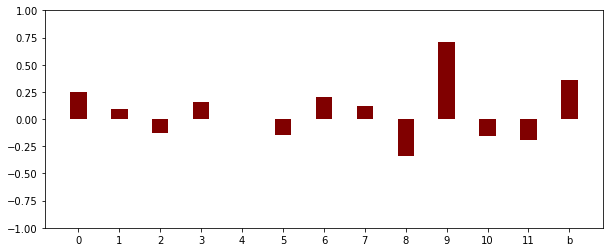

In [82]:
plot_coefs(erm_trainer.f.weight.detach()[0], bias=erm_trainer.f.bias.detach())

### RRM - all

In [41]:
# use all collected data 
print("RRM with all collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
rrm_all_trainer = IterativeNonStrategicTrainer(f_fac, s_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=False)
rrm_all_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

RRM with all collected data:
time step: 1
-----learning f
trained 14 epochs. val acc: 0.7766666666666666
StochasticModel: 21.25% flips
	total move: 0.213, pos move (out of total move): 0.211, neg move (out of total move): 0.789,
	pos turn to neg (out of pos move): 0.022222222222222223, neg turn to pos (out of neg move): 0.020833333333333332,
	 f.bias: 0.948
	Accuracy: 0.6645
StochasticModel: 22.5% flips
time step: 2
-----learning f
trained 34 epochs. val acc: 0.8055555555555556
StochasticModel: 21.15% flips
	total move: 0.213, pos move (out of total move): 0.235, neg move (out of total move): 0.765,
	pos turn to neg (out of pos move): 0.01, neg turn to pos (out of neg move): 0.003067484662576687,
	 f.bias: 0.994
	Accuracy: 0.675
StochasticModel: 21.5% flips
time step: 3
-----learning f
trained 23 epochs. val acc: 0.7595238095238095
StochasticModel: 21.15% flips
	total move: 0.215, pos move (out of total move): 0.226, neg move (out of total move): 0.774,
	pos turn to neg (out of pos mov

### RRM - last

In [70]:
# use last samples 
print("RRM with only last collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
rrm_last_trainer = IterativeNonStrategicTrainer(f_fac, s_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=False)
rrm_last_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=True)

RRM with only last collected data:
time step: 1
-----learning f
trained 14 epochs. val acc: 0.7766666666666666
StochasticModel: 21.25% flips
	total move: 0.213, pos move (out of total move): 0.211, neg move (out of total move): 0.789,
	pos turn to neg (out of pos move): 0.022222222222222223, neg turn to pos (out of neg move): 0.020833333333333332,
	 f.bias: 0.948
	Accuracy: 0.6645
StochasticModel: 22.5% flips
time step: 2
-----learning f
trained 21 epochs. val acc: 0.6666666666666666
StochasticModel: 21.4% flips
	total move: 0.231, pos move (out of total move): 0.47, neg move (out of total move): 0.53,
	pos turn to neg (out of pos move): 0.03225806451612903, neg turn to pos (out of neg move): 0.044897959183673466,
	 f.bias: 0.19
	Accuracy: 0.7385
StochasticModel: 21.5% flips
time step: 3
-----learning f
trained 21 epochs. val acc: 0.8
StochasticModel: 21.8% flips
	total move: 0.313, pos move (out of total move): 0.234, neg move (out of total move): 0.766,
	pos turn to neg (out of pos m

### ERMc

In [74]:
# RRM using only x_c, using all collected samples
print("ERMc")
set_seed(seed)
delta = QuadraticCostDelta(None, x1_cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U[n_clean_train_samples:])
erm_c_trainer = IterativeNonStrategicTrainer(x1_f_fac, s_h_star, delta, s_dist, X1_clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, use_only_x1=True)
erm_c_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

ERMc
time step: 1
-----learning f
trained 20 epochs. val acc: 0.7366666666666667
StochasticModel: 21.25% flips
	total move: 0.262, pos move (out of total move): 0.162, neg move (out of total move): 0.838,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (out of neg move): 0.009111617312072893,
	 f.bias: 0.778
	Accuracy: 0.5625
StochasticModel: 21.5% flips
time step: 2
-----learning f
trained 17 epochs. val acc: 0.7277777777777777
StochasticModel: 21.35% flips
	total move: 0.242, pos move (out of total move): 0.197, neg move (out of total move): 0.803,
	pos turn to neg (out of pos move): 0.010526315789473684, neg turn to pos (out of neg move): 0.01288659793814433,
	 f.bias: 0.706
	Accuracy: 0.5955
StochasticModel: 21.5% flips
time step: 3
-----learning f
trained 13 epochs. val acc: 0.7214285714285714
StochasticModel: 21.3% flips
	total move: 0.219, pos move (out of total move): 0.164, neg move (out of total move): 0.836,
	pos turn to neg (out of pos move): 0.0, neg turn to pos (

### SERMr

In [51]:
# SERM f using only only x2
print("SERMr:")
f = x2_f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, x2_cost, tau)
serm_r_trainer = StrategicTrainer(f, delta, full_X2_train_dl, X2_val, Y_val, X2_test, Y_test, opt, hinge_loss, cost_scale=cost_scale)
serm_r_trainer.train(epochs, True)
serm_r_acc = test_strategic_only_X2_model(f, s_h_star, delta, X1_test, X2_test, U_test)
serm_r_res = serm_r_trainer.collect_trainer_results_using_only_x2(s_h_star, delta, full_data, x1_dim)

SERMr:
trained 8 epochs. val acc: 0.798
StochasticModel: 21.1% flips
StochasticModel: 26.97% flips
	Accuracy: 0.783


### SERM

In [189]:
# SERM f on full input
print("SERM:")
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, cost, tau)
serm_trainer = StrategicTrainer(f, delta, full_train_dl, X_val, Y_val, X_test, Y_test, opt, hinge_loss, cost_scale=cost_scale)
serm_trainer.train(epochs, True)
serm_acc = test_strategic(f, s_h_star, delta, X_test, U_test, x1_dim)
serm_res = serm_trainer.collect_trainer_results(s_h_star, delta, full_data, x1_dim)
   

SERM:
trained 8 epochs. val acc: 0.788
StochasticModel: 19.95% flips
	total move: 0.53, pos move (out of total move): 0.711, neg move (out of total move): 0.289,
	pos turn to neg (out of pos move): 0.021220159151193633, neg turn to pos (out of neg move): 0.14052287581699346,
	 f.bias: -0.39
	Accuracy: 0.7975


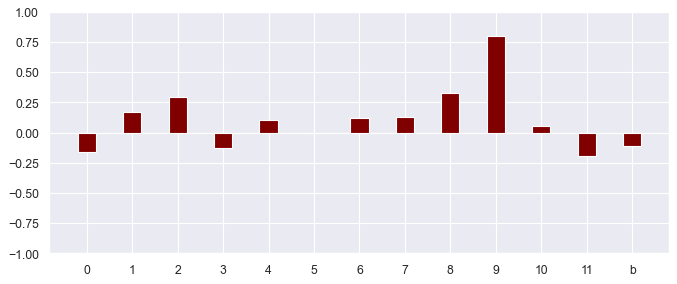

In [395]:
plot_coefs(serm_trainer.f.weight.detach()[0], bias=serm_trainer.f.bias.detach())

### RSRM - all

In [55]:
# RSRM using all collected data
print("RSRM with all collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
rsrm_all_trainer = IterativeStrategicTrainer(f_fac, s_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, cost_scale)
rsrm_all_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=False)

RSRM with all collected data:
time step: 1
-----learning f
trained 14 epochs. val acc: 0.7766666666666666
StochasticModel: 21.0% flips
	total move: 0.163, pos move (out of total move): 0.635, neg move (out of total move): 0.365,
	pos turn to neg (out of pos move): 0.033816425120772944, neg turn to pos (out of neg move): 0.10084033613445378,
	 f.bias: 0.149
	Accuracy: 0.782
StochasticModel: 28.5% flips
time step: 2
-----learning f
trained 12 epochs. val acc: 0.7805555555555556
StochasticModel: 21.1% flips
	total move: 0.179, pos move (out of total move): 0.624, neg move (out of total move): 0.376,
	pos turn to neg (out of pos move): 0.03125, neg turn to pos (out of neg move): 0.07407407407407407,
	 f.bias: 0.136
	Accuracy: 0.775
StochasticModel: 25.0% flips
time step: 3
-----learning f
trained 19 epochs. val acc: 0.7833333333333333
StochasticModel: 20.9% flips
	total move: 0.322, pos move (out of total move): 0.684, neg move (out of total move): 0.316,
	pos turn to neg (out of pos move)

### RSRM - last

In [57]:
# RSRM using only last collected data
print("RSRM with only last collected data:")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
rsrm_last_trainer = IterativeStrategicTrainer(f_fac, s_h_star, delta, s_dist, clean_data, n_features, x1_dim, n_samples_per_round, hinge_loss, cost_scale)
rsrm_last_trainer.train(time_steps, epochs, lr, batch_size, test_each_step=True, verbose=True, use_only_last_samples=True)

RSRM with only last collected data:
time step: 1
-----learning f
trained 14 epochs. val acc: 0.7766666666666666
StochasticModel: 21.0% flips
	total move: 0.163, pos move (out of total move): 0.635, neg move (out of total move): 0.365,
	pos turn to neg (out of pos move): 0.033816425120772944, neg turn to pos (out of neg move): 0.10084033613445378,
	 f.bias: 0.149
	Accuracy: 0.782
StochasticModel: 28.5% flips
time step: 2
-----learning f
trained 12 epochs. val acc: 0.55
StochasticModel: 20.7% flips
	total move: 0.309, pos move (out of total move): 0.672, neg move (out of total move): 0.328,
	pos turn to neg (out of pos move): 0.04096385542168675, neg turn to pos (out of neg move): 0.15270935960591134,
	 f.bias: 0.011
	Accuracy: 0.787
StochasticModel: 24.5% flips
time step: 3
-----learning f
trained 21 epochs. val acc: 0.7333333333333333
StochasticModel: 21.2% flips
	total move: 0.141, pos move (out of total move): 0.546, neg move (out of total move): 0.454,
	pos turn to neg (out of pos m

### CSERM

In [60]:
print("CSERM")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
cserm_trainer = IterativeCausalStrategicTrainer(f_fac, h_fac, s_h_star, delta, s_dist, clean_data, x1_dim, x2_dim, n_samples_per_round, hinge_loss, cross_entropy_loss_for_h,
                                          exploration_params=None, should_estimate_density=True, pca=None, cost_scale=cost_scale)
cserm_trainer.train(time_steps, epochs, lr, lr, batch_size, verbose=True)

ICSERM
time step: 1
-----learning h
trained 11 epochs. val acc: 0.7833333333333333
	Accuracy: 0.7833333333333333

-----learning f
trained 14 epochs. val acc: 0.794
trained 29 epochs. val acc: 0.966
StochasticModel: 13.35% flips
	total move: 0.59, pos move (out of total move): 0.69, neg move (out of total move): 0.31,
	pos turn to neg (out of pos move): 0.036855036855036855, neg turn to pos (out of neg move): 0.5327868852459017,
	 f.bias: -1.611
	mean likelihood of moving points: 0.5955037474632263
	Accuracy: 0.848

-----collecting samples


KeyboardInterrupt: 

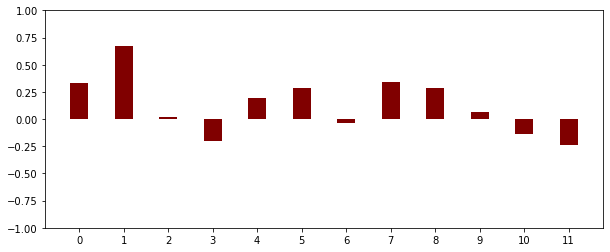

In [201]:
plot_coefs(cserm_trainer.f_list[0].weight.detach()[0])

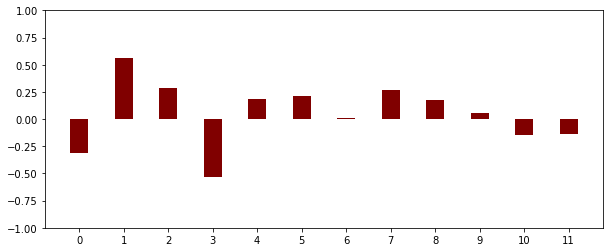

In [202]:
plot_coefs(cserm_trainer.f_list[-1].weight.detach()[0])

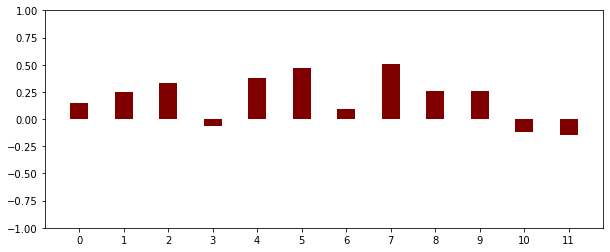

In [203]:
plot_coefs(serm_trainer.f.weight.detach()[0])

### CSERM with exploration

In [281]:
print("ICSERM with exploration")
set_seed(seed)
delta = QuadraticCostDelta(None, cost, tau)
exploration_params = ExplorationParams(should_use=True, coef=10, decay=0.4)
# create dist object from the samples that not included in the partial clean data
s_dist = SequentialDistribution(x1_dim, X_U_train[n_clean_train_samples:])
cserm_exp_trainer = IterativeCausalStrategicTrainer(f_fac, h_fac, s_h_star, delta, s_dist, clean_data, x1_dim, x2_dim, n_samples_per_round, hinge_loss, cross_entropy_loss_for_h,
                                          exploration_params=exploration_params, should_estimate_density=True, pca=None, cost_scale=cost_scale)
cserm_exp_trainer.train(time_steps, epochs, lr, lr, batch_size, verbose=True)

ICSERM with exploration
time step: 1
-----learning h
trained 9 epochs. val acc: 0.7933333333333333
	Accuracy: 0.7933333333333333

-----learning f
trained 12 epochs. val acc: 0.824
trained 14 epochs. val acc: 0.578
StochasticModel: 7.5% flips
	total move: 0.904, pos move (out of total move): 0.432, neg move (out of total move): 0.568,
	pos turn to neg (out of pos move): 0.01792573623559539, neg turn to pos (out of neg move): 0.2804284323271665,
	 f.bias: -1.616
	mean likelihood of moving points: 9.490294360148255e-06
	Accuracy: 0.5995

-----collecting samples
time step: 2
-----learning h
trained 14 epochs. val acc: 0.8472222222222222
	Accuracy: 0.8472222222222222

-----learning f
trained 12 epochs. val acc: 0.824
trained 13 epochs. val acc: 0.618
StochasticModel: 8.4% flips
	total move: 0.927, pos move (out of total move): 0.438, neg move (out of total move): 0.562,
	pos turn to neg (out of pos move): 0.022167487684729065, neg turn to pos (out of neg move): 0.2670509125840538,
	 f.bias:

### CSERM-h*

In [209]:
print("CSERM with u and h*")
set_seed(seed)
f = f_fac()
opt = Adam(f.parameters(), lr=lr)
delta = QuadraticCostDelta(f, cost, tau)
helper = HelperModel(h_star)
cserm_h_star_trainer = CausalStrategicTrainerWithU(f, helper, delta, X_U_train_dl, full_train_dl, X_val, X_U_val, Y_val, X_test, n_features, x1_dim, opt, hinge_loss, cost_scale=cost_scale)
cserm_h_star_trainer.train(epochs, False)
print("causal strategic f with h_star using u:")
cserm_h_star_acc = test_strategic(f, s_h_star, delta, X_test, U_test, x1_dim)
cserm_h_star_res = cserm_h_star_trainer.collect_trainer_results(s_h_star, delta, full_data, x1_dim)

CSERM with u and h*
trained 8 epochs. val acc: 0.788
trained 10 epochs. val acc: 0.944
causal strategic f with h_star using u:
StochasticModel: 12.3% flips
	total move: 0.576, pos move (out of total move): 0.703, neg move (out of total move): 0.297,
	pos turn to neg (out of pos move): 0.051787916152897656, neg turn to pos (out of neg move): 0.6929824561403509,
	 f.bias: -2.045
	Accuracy: 0.8725
